In [3]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
from bisect import bisect_left, bisect_right
import math

In [7]:
start_r = 0.05
num_paths = 200
a = 0.01
b = 0.05
sigma = 0.01
swap_term = 0.5
swap_payments = 3

In [8]:
def bond_price(r,a,b,sigma,t,T):
    B = (1 - np.exp(-a*(T-t)))/a
    A_1 = (B - T + t) * (a**2*b - (sigma**2)/2)/(a**2)
    A_2 = (sigma**2 * B**2) / (4 * a)
    A = np.exp(A_1 - A_2)
    P = A * np.exp(-B*r)
    return P

class Yield_Curve:
    def __init__(self, times, yields):
        self.times = times
        self.yields = yields
    def get_rate(self,time):
        if time in self.times:
            return self.yields[self.times.index(time)]
        if time <= 0:
            return self.yields[0]
        i = bisect_left(self.times, time)
        dist = (time - self.times[i-1])/(self.times[i] - self.times[i-1])
        diff = (self.yields[i] - self.yields[i-1])
        rate = dist * diff + self.yields[i-1]
        return rate
    def get_price(self, time):
        if time == 0 :
            return 1
        return np.exp(-self.get_rate(time)*time)
        
class Swap:
    def __init__(self, num_payments, swap_term, P):
        self.swap_term = swap_term
        self.num_payments = num_payments
        # self.payment_dates = np.arange(offset,offset + (num_payments)*compound_rate,swap_Term)
        self.fixed = self.set_fixed_rate(P)
        self.description = f"""{self.fixed*100}% for LIBOR swap, with duration {self.num_payments*swap_term}
        years"""
    def value(self, t, P):
        #Get remaining payments
        payments = math.ceil(t/self.swap_term)
        remaining = np.arange(payments*self.swap_term, self.swap_term*(self.num_payments + 1), self.swap_term)
        if len(remaining) == 0:
            return 0
        leg1 = P(remaining[0])
        leg2 = P(remaining[-1])
        print(leg2)
        leg3 = self.fixed*self.swap_term*np.sum(list(map(P, remaining[1:])))
        print("----")
        print(leg1)
        print(leg2)
        print(leg3)
        print("----")
        return leg1 - leg2 - leg3
    def set_fixed_rate(self, P):
        last_date = self.num_payments * self.swap_term
        all_dates = np.arange(self.swap_term, last_date +self.swap_term, self.swap_term)
        fixed1 = (1 - P(last_date))/(np.sum(list(map(P, all_dates)))*self.swap_term)
        return fixed1

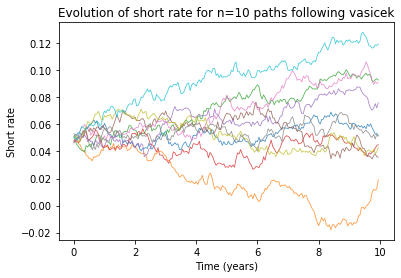

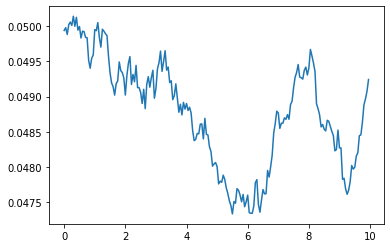

In [14]:
#formula for a step for the short rate for vasicek with Montecarlo sampling
def simulate_short_rate(r,a,b,sigma,time):
    delta_r = a*(b - r)*time + np.sqrt(time) * sigma * np.random.normal(0,1)
    return r + delta_r

#Use monte carlo sampling to generate paths of the short rate 

paths = []
time = np.arange(0,10,0.05)
time_delta = 0.05
for j in range(num_paths):
    r = start_r
    res = []
    for i in time:
        r = simulate_short_rate(r,a,b,sigma,time_delta)
        res.append(r)
    paths.append(res)

plt.title(f"Evolution of short rate for n={10} paths following vasicek")
for i in range(10):
    plt.plot(time,paths[i],lw=0.8, alpha=0.8) 
# plt.axis([0,10,0.0,0.2])
plt.xlabel("Time (years)")
plt.ylabel("Short rate")
plt.show()

apaths = np.mean(np.array(paths),axis=0)
plt.plot(time,apaths)
plt.show()

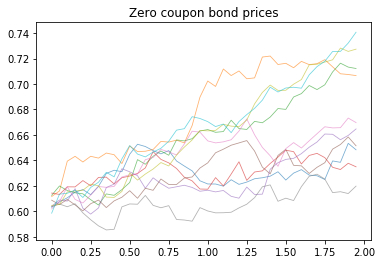

In [150]:
prices = []
for i in range(len(paths)):
    price = []
    for j in range(len(paths[i])):
        price.append(bond_price(paths[i][j], a,b,sigma,time[j], 10))
    prices.append(price)


plt.title(f"Zero coupon bond prices")
for i in range(10):
    plt.plot(time,np.array(prices)[i,:],lw=0.8, alpha=0.6)

In [129]:
swap1 = Swap(3, swap_term, lambda x: bond_price(0.05,a,b,sigma,0,x))
print(swap1.fixed)
print(bond_price(0.05,a,b,sigma,0,1.5))
print(swap1.value(0, lambda x: bond_price(0.05,a,b,sigma,0,x)))

0.050629867165173655
0.9277440023544077
----
1.0
0.9277440023544077
0.07225599764559232
----
0.0


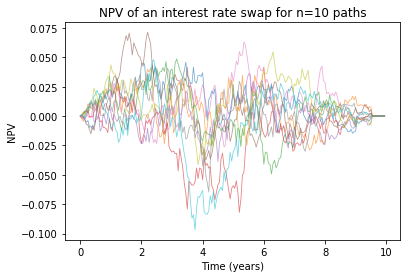

In [117]:
exposures = []

for i in range(len(paths)):
    exposure = []
    for j in range(len(paths[i])):
        exposure.append(swap1.value(time[j], lambda x: bond_price(paths[i][j],a,b,sigma,time[j],x)))
    exposures.append(exposure)

plt.title(f"NPV of an interest rate swap for n=10 paths")
for i in range(10):
    plt.plot(time,np.array(exposures)[i,:],lw=0.8, alpha=0.6)
plt.ylabel("NPV")
plt.xlabel("Time (years)")
plt.show()

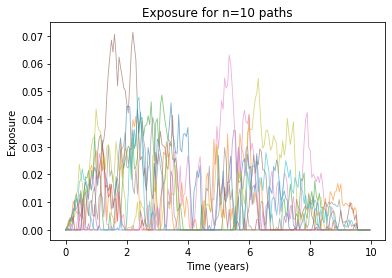

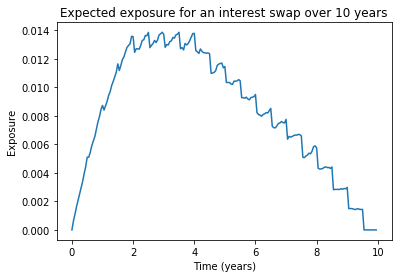

In [119]:
exposures = np.array(exposures)

plt.title(f"Exposure for n=10 paths")
plt.xlabel("Time (years)")
plt.ylabel("Exposure")
exposures[exposures < 0] = 0 
for i in range(10):
    plt.plot(time,np.array(exposures)[i,:],lw=0.8, alpha=0.6)
plt.show()
meanexp = np.mean(exposures,axis=0)
plt.plot(time, meanexp)
plt.title("Expected exposure for an interest swap over 10 years")
plt.xlabel("Time (years)")
plt.ylabel("Exposure")
plt.show()

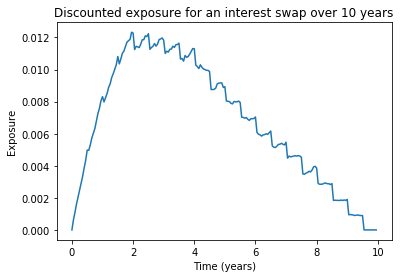

In [120]:
discounted_exp = meanexp * np.exp(-time*0.05)
plt.title("Discounted exposure for an interest swap over 10 years")
plt.xlabel("Time (years)")
plt.ylabel("Exposure")
plt.plot(time, discounted_exp)
plt.show()

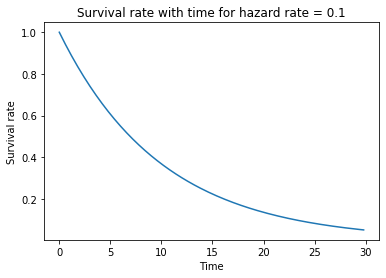

In [121]:
hazard_rate = 0.1
default_rate =  1 - np.exp(-hazard_rate*time)

default_curve = np.exp(-hazard_rate*np.arange(0,30,0.2))
plt.plot(np.arange(0,30,0.2), default_curve)
plt.title(f"Survival rate with time for hazard rate = {hazard_rate}")
plt.xlabel("Time")
plt.ylabel("Survival rate")
plt.show()

In [122]:
CVA = (1-0.4) * np.sum(default_rate * discounted_exp * time[1] - time[0])
print(f"CVA for {swap1.description} : {CVA}")

CVA for 5.061628629422771% for LIBOR swap, with duration 10.0
        years : 0.012488461157128873
